In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from mpl_toolkits.basemap import Basemap

%matplotlib inline
plt.style.use('fivethirtyeight')

C:\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# gender_age

Let's take a quick view of all the files to understand the data we have. First, the training a test set

In [2]:
gender_age_train = pd.read_csv('.\\raw_data\gender_age_train.csv')
gender_age_test = pd.read_csv('.\\raw_data\gender_age_test.csv')

In [3]:
gender_age_train.head()

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [15]:
gender_age_test.head()

,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


Group is the variable we need to predict.
Where is gender and age for the test data??

In [11]:
print("Number of categories for group: ", len(gender_age_train.group.value_counts()))
gender_age_train.group.value_counts()

Number of categories for group:  12


M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

In [16]:
gender_age_train.isnull().sum()

device_id    0
gender       0
age          0
group        0
dtype: int64

In [17]:
gender_age_test.isnull().sum()

device_id    0
dtype: int64

In [18]:
print(gender_age_train.shape)
print(gender_age_test.shape)

(74645, 4)
(112071, 1)


Let's check age and gender 

In [45]:
print("Gender")
gender_age_train.gender.value_counts()

Gender


M    47904
F    26741
Name: gender, dtype: int64

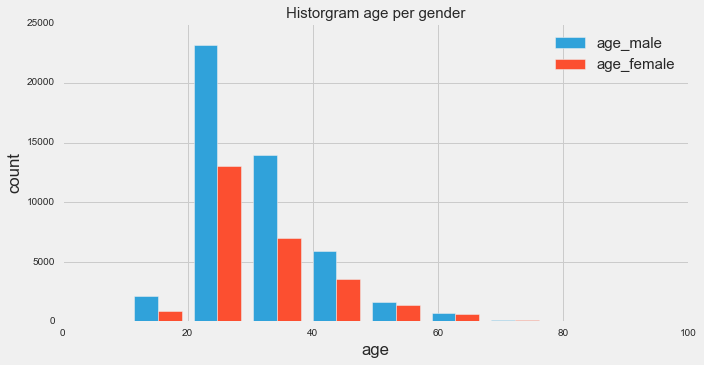

In [68]:
fig = plt.figure(figsize=(10,5))
age_male = gender_age_train[gender_age_train.gender == 'M'].age
age_female = gender_age_train[gender_age_train.gender == 'F'].age
plt.hist([age_male, age_female], stacked=False)
plt.title("Historgram age per gender", size=15)
plt.legend(['age_male', 'age_female'],prop={'size': 15})
plt.xlabel("age")
plt.ylabel("count")
plt.show()

In [70]:
gender_age_train.age.describe()

count    74645.000000
mean        31.410342
std          9.868735
min          1.000000
25%         25.000000
50%         29.000000
75%         36.000000
max         96.000000
Name: age, dtype: float64

It looks there are some outliers (ages 1). It only has one occurence so we'll delete it

In [99]:
gender_age_train.age.value_counts().reset_index().sort('index')[:10]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,index,age
83,1,1
75,6,4
72,10,5
73,11,4
65,12,14
63,13,15
57,14,35
53,15,65
43,16,162
35,17,401


# events, app_events, app_labels

In [5]:
events = pd.read_csv(".\\raw_data\\events.csv")
app_events = pd.read_csv(".\\raw_data\\app_events.csv")

In [4]:
print(events.shape)
print(events.isnull().sum())
events.head()

(252950, 5)
event_id     0
device_id    0
timestamp    0
longitude    0
latitude     0
dtype: int64


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


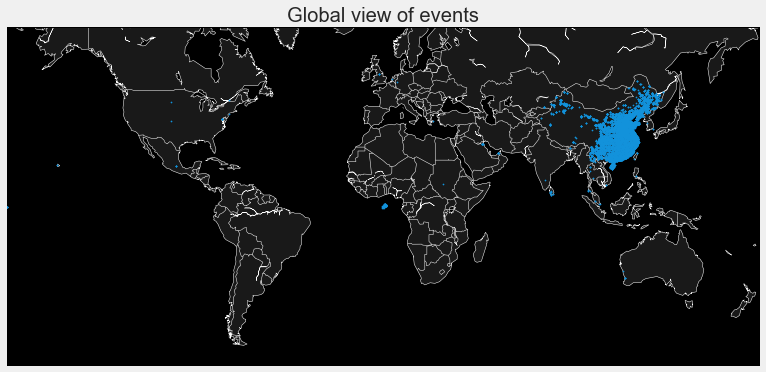

In [12]:
# Set up plot
df_events_sample = events.sample(n=100000)
plt.figure(1, figsize=(12,6))

# Mercator of World
m1 = Basemap(projection='merc', llcrnrlat=-60,urcrnrlat=65,llcrnrlon=-180, urcrnrlon=180,lat_ts=0,resolution='c')

m1.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m1.drawmapboundary(fill_color='#000000')                # black background
m1.drawcountries(linewidth=0.5, color="w")              # thin white line for country borders
m1.drawcoastlines(linewidth=0.5, color="w")

# Plot the data. 1. convert long and lat to cartesian coords. 2. Plot it
mxy = m1(df_events_sample["longitude"].tolist(), df_events_sample["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="#1292db", lw=0, alpha=1, zorder=5)

# title and show
plt.title("Global view of events")
plt.show()

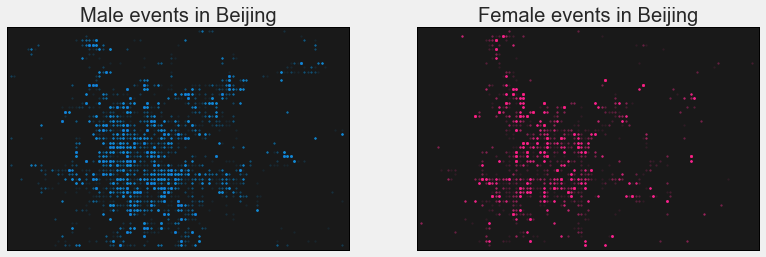

In [19]:
# Sample it down to only the Beijing region
lon_min, lon_max = 116, 117
lat_min, lat_max = 39.75, 40.25

idx_beijing = (events["longitude"]>lon_min)&(events["longitude"]<lon_max)&(events["latitude"]>lat_min)&(events["latitude"]<lat_max)

df_events_beijing = events[idx_beijing]

# Load the train data and join on the events
#df_train = pd.read_csv("../input/gender_age_train.csv", dtype={'device_id': np.str})

df_plot = pd.merge(gender_age_train, df_events_beijing, on="device_id", how="inner")

df_m = df_plot[df_plot["gender"]=="M"]
df_f = df_plot[df_plot["gender"]=="F"]

# Male/female plot
fig = plt.figure(4, figsize=(12,6))

plt.subplot(121)
m4a = Basemap(projection='merc',
             llcrnrlat=lat_min,
             urcrnrlat=lat_max,
             llcrnrlon=lon_min,
             urcrnrlon=lon_max,
             lat_ts=35,
             resolution='c')
m4a.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m4a.drawmapboundary(fill_color='#000000')                # black background
m4a.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders
mxy = m4a(df_m["longitude"].tolist(), df_m["latitude"].tolist())
m4a.scatter(mxy[0], mxy[1], s=5, c="#1292db", lw=0, alpha=0.1, zorder=5)
plt.title("Male events in Beijing")

plt.subplot(122)
m4b = Basemap(projection='merc',llcrnrlat=lat_min,urcrnrlat=lat_max,llcrnrlon=lon_min,urcrnrlon=lon_max,lat_ts=35,resolution='c')
m4b.fillcontinents(color='#191919',lake_color='#000000') # dark grey land, black lakes
m4b.drawmapboundary(fill_color='#000000')                # black background
m4b.drawcountries(linewidth=0.1, color="w")              # thin white line for country borders
mxy = m4b(df_f["longitude"].tolist(), df_f["latitude"].tolist())
m4b.scatter(mxy[0], mxy[1], s=5, c="#fd3096", lw=0, alpha=0.1, zorder=5)
plt.title("Female events in Beijing")

plt.show()

In [5]:
print(app_events.shape)
print(app_events.isnull().sum())
app_events.head()

(2473067, 4)
event_id        0
app_id          0
is_installed    0
is_active       0
dtype: int64


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [16]:
#event_group = app_events.groupby('event_id').count()
#event_group.head()

In [6]:
app_labels = pd.read_csv(".\\raw_data\\app_labels.csv")
print(app_labels.shape)
print(app_labels.isnull().sum())
app_labels.head()

(459943, 2)
app_id      0
label_id    0
dtype: int64


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


We have to look for a way of combining this data grouped by devide_id 

# phone_brand_device_model

In [11]:
phone_brand_device_model = pd.read_csv(".\\raw_data\\phone_brand_device_model.csv")
print(phone_brand_device_model.shape)
print(phone_brand_device_model.isnull().sum())
phone_brand_device_model.head()

(187245, 3)
device_id       0
phone_brand     0
device_model    0
dtype: int64


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


# label categories

In [13]:
label_categories = pd.read_csv(".\\raw_data\\label_categories.csv")
print(label_categories.shape)
print(label_categories.isnull().sum())
label_categories.head()

(930, 2)
label_id    0
category    3
dtype: int64


,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


So far makes sense to:

1. Aggregate longitud and latidud
2. bag of apps (installed and enabled)
3. phone brand and device model

Not sure how what to do with

1. how to agg timestamps
